# **Análise de Crédito**
## Luciano Fernandes

---


## __SUMÁRIO__
### O estudo abaixo está estruturado da seguinte forma:
- Introdução
- Importação de bibliotecas e dados
- Análise exploratória dos dados
- Pré-processamento dos dados
- Construção do modelo preditivo de classificação
- Interpretação do modelo
- Avaliação do modelo
- Predição para dados de teste
- Curva ROC
- Conclusão
___

## __INTRODUÇÃO__
##### Os clientes que solicitam crédito com garantia de automóvel passam por um conjunto de regras automáticas que dizem se ele será ou não pré-aprovado. Em seguida esse cliente pode ser atendido por um consultor de negócios que dirá se o cliente será ou não levado para a análise de crédito.
##### O objetivo desse estudo é atribuir para cada cliente pré-aprovado uma probabilidade de ser ou não levado para a análise de crédito. Dessa forma, os clientes com maior probabilidade de serem enviados para análise de crédito serão priorizados no atendimento.
##### Para criar um modelo de classificação, usaremos dados históricos de clientes que foram pré-aprovados e em seguida foram ou não enviados para análise de crédito. Queremos que esse modelo seja capaz de usar as características de um cliente para atribuir a ele uma probabilidade dele ser ou não enviado para a análise de crédito.

___
## __IMPORTAÇÃO DE BIBLIOTECAS E DADOS__

In [1]:
# conda install -c conda-forge keras
# conda install -c conda-forge tensorflow

import pandas as pd
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense,Activation
import keras

In [2]:
# Importar dados
dataset = pd.read_csv('dataset.csv')

---

## __ANÁLISE EXPLORATÓRIA DOS DADOS__
##### Nesta sessão será feita uma análise exploratória dos dados com o objetivo de conhecer melhor as variáveis disponíveis.
##### Esta análise exploratória dos dados nos ajudará a identificar quais limpezas e tratamentos as variáveis precisarão receber na sessão de Pré-processamento.


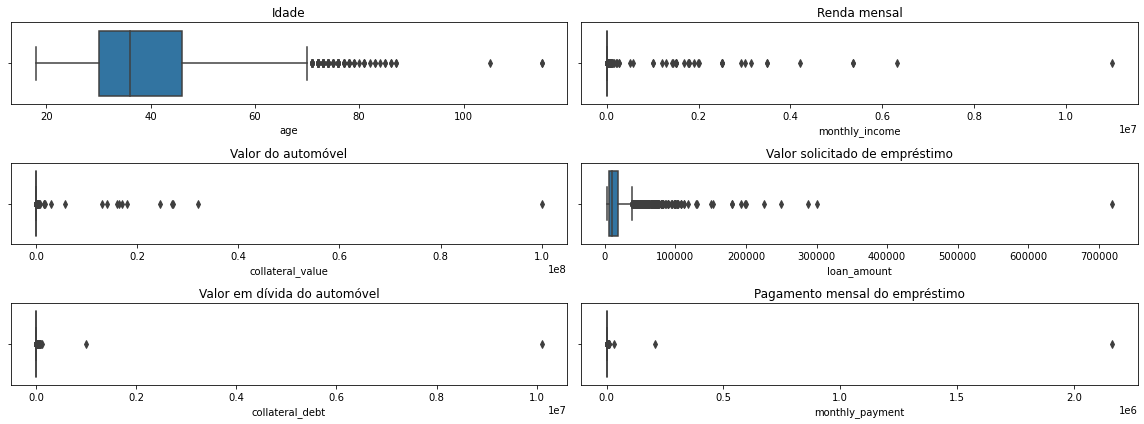

In [6]:
df = dataset.copy()

# Retirar clientes que não foram pré-aprovados, pois estes não farão parte do nosso estudo.
df = df[df['pre_approved'] == 1]

# Plotar boxplot de algumas variáveis numéricas
fig, ax = plt.subplots(3, 2, figsize=(16,6))
sns.boxplot(x=df['age'], ax=ax[0,0]).set_title("Idade")
sns.boxplot(x=df['monthly_income'], ax=ax[0,1]).set_title("Renda mensal")
sns.boxplot(x=df['collateral_value'], ax=ax[1,0]).set_title("Valor do automóvel")
sns.boxplot(x=df['loan_amount'], ax=ax[1,1]).set_title("Valor solicitado de empréstimo")
sns.boxplot(x=df['collateral_debt'], ax=ax[2,0]).set_title("Valor em dívida do automóvel")
sns.boxplot(x=df['monthly_payment'], ax=ax[2,1]).set_title("Pagamento mensal do empréstimo")
fig.tight_layout() #Ajustar plots
plt.show()


#### Temos outliers (valores discrepantes) nas variáveis numéricas acima. Alguns deles não são plausíveis, são dados incorretos. Trataremos esse problema na sessão de Pré-processamento.

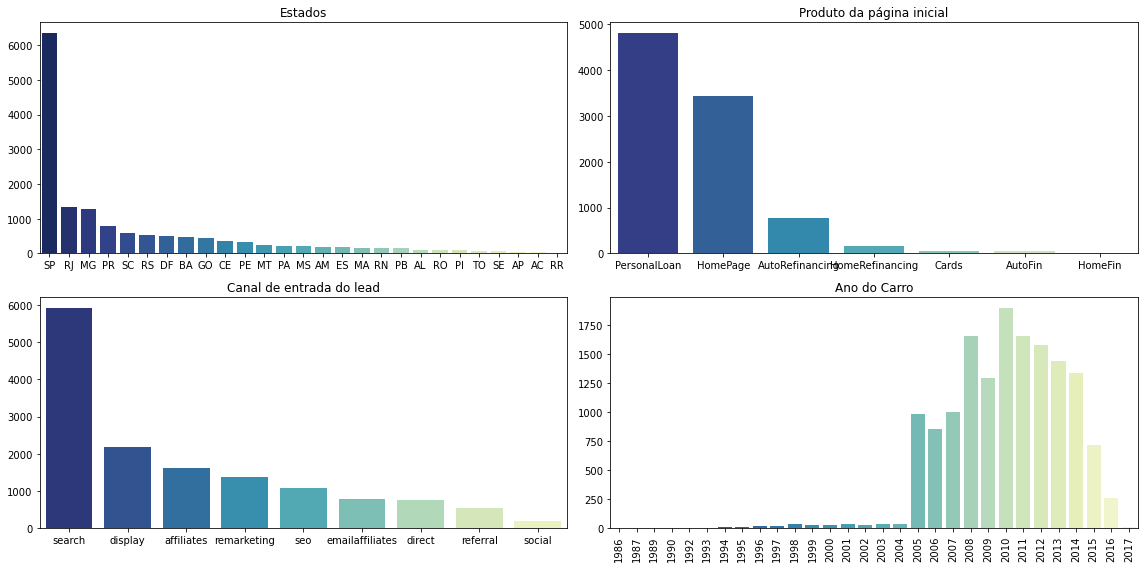

In [8]:
# Plotar gráficos de barra para mais algumas variáveis
fig, ax = plt.subplots(2,2, figsize=(16,8))
sns.barplot(x=df['state'].value_counts().index, y=df['state'].value_counts().values, data=df, palette='YlGnBu_r', ax=ax[0,0]).set_title("Estados")
sns.barplot(x=df['landing_page_product'].value_counts().index, y=df['landing_page_product'].value_counts().values, data=df, palette='YlGnBu_r', ax=ax[0,1]).set_title("Produto da página inicial")
sns.barplot(x=df['channel'].value_counts().index, y=df['channel'].value_counts().values, data=df, palette='YlGnBu_r', ax=ax[1,0]).set_title("Canal de entrada do lead")
sns.barplot(x=df['auto_year'].value_counts().index.astype(int), y=df['auto_year'].value_counts().values, data=df, palette='YlGnBu_r', ax=ax[1,1]).set_title("Ano do Carro")

plt.xticks(rotation=90) 
fig.tight_layout() #Ajustar plots
plt.show()

In [9]:
# Analisar proporção de clientes enviados para análise de crédito (variável resposta)
plt_sta = pd.concat([df['sent_to_analysis'].value_counts(), df['sent_to_analysis'].value_counts(normalize=True)], axis=1)
plt_sta.columns = ['Quantidade', 'prop']
plt_sta

,Quantidade,prop
0.0,11730,0.782052
1.0,3269,0.217948


#### 21.8% dos clientes do banco de dados foram enviados para análise de crédito

---

## __PRÉ-PROCESSAMENTO DOS DADOS__
### - Limpeza e tratamento

In [10]:
# Vamos remover do banco de dados algumas linhas com dados faltantes, visto que são poucos casos e são de variáveis que podem ser muito importantes
# para o modelo de classificação.

# Retirar os 3 clientes com mais de 100 anos. Justificativa: provavelmente são dados incorretos, principalmente os clientes com 115 anos.
df = df[df['age'] <= 100]

# Retirar os 4 clientes com renda mensal de até R$ 17,00. Justificativa: provavelmente são dados incorretos.
df = df[df['monthly_income'] >= 100]

# Retirar clientes com renda mensal a partir de R$100.000,00. Justificativa: São clientes com renda mensal muito alta e valor de automóvel muito 
# baixo em relação à renda recebida, isso coloca em dúvida a veracidade dos dados. É muito improvável que alguém com renda mensal tão alta tenha
# um automóvel de valor tão baixo, e principalmente, ainda precise tomar empréstimo usando esse automóvel como garantia.
df = df[df['monthly_income'] < 100000]

# Retirar os 2 clientes com valor de automóvel muito baixo (até R$ 26,87), além de alguns clientes sem valor de automóvel informado.
df = df[df['collateral_value'] > 1000]

# Retirar clientes com valores de automóvel muito alto (a partir de R$ 500.000,00). 
# Justificativa: valores irreais, principalmente quando comparado a renda mensal e modelo de carro informado.
df = df[df['collateral_value'] < 500000]

# Obs: Existem outros carros de valores que não são plausíveis para o modelo de carro informado (ex: Pálio 1.0 no valor de R$ 160.000,00). 
# Seria importante fazer um trabalho mais aprofundado de levantamento de preços estimados para os modelos (tabela Fipe, por exemplo). 
# E em seguida comparar com valor informado do automóvel para checar se não há uma disparidade muito grande.
# Porém seria necessário consultar caso a caso da variável que informa o modelo do carro e comparar com o valor informado, isso impediria que esse script
# seja reproduzível. Outra possibilidade seria desenvolver um algorítimo de reconhecimento de texto para identificar o modelo informado do carro e 
# comparar com o valor, mas tal algoritimo foge do escopo estabelecido para esse estudo.

# Na variável "loan_amount" (valor de empréstimo solicitado pelo cliente) existem valores exatamente iguais para clientes diferentes, 
# isso levanta suspeitas de inputs incorretos.
# Exemplo 1 : Existem 9 clientes com valor de empréstimo solicitado de R$ 68.389,06. Esses clientes possuem dados diferentes, até mesmo as cidades, 
# porém o valor de renda mensal informado são todos iguais (R$ 10.000,00) e valor de empréstimo solicitado de R$ 68389,06 (igual até nos centavos).
# Exemplo 2: Existem 4 clientes com valor de empréstimo solicitado de R$ 44.452,89. Como até os centavos estão iguais, também é um caso de 
# suspeita de erro nos inputs.
# Existem vários casos como esses dois citados acima. A ação recomendada é verificar se houve algum erro na exportação dos dados, erros de input, etc. 
# Como não possuo acesso à formas de fazer tal verificação, trabalharemos em cima da suposição de que esses valores estão corretos.

# Transformar células vazias da variável "collateral_debt" em 0 , pois são clientes que não possuem dívida com o automóvel.
df['collateral_debt'].fillna(0, inplace=True)

# Retirar um valor discrepante de R$ 10.100.000,00.
df = df[df['collateral_debt'] < 1000000]

# Transformar células vazias da variável "verified_restriction" em 0 , pois trataremos os clientes que não tiverem sua situação consultada da 
# mesma forma que os que foram consultados e não possuem nenhuma restrição/pendência.
df['verified_restriction'].fillna(0, inplace=True)

# Copiar valores da variável "verified_restriction" para as células vazias da variável "informed_restriction" para preencher os missing values.
df['informed_restriction'].fillna(df['verified_restriction'], inplace=True)

# Apagar os 2 maiores valores (Acima de R$ 200.000,00). Justificativa: Não são valores plausíveis para o valor do emprestimo.
df.loc[df['monthly_payment'] > 200000,'monthly_payment'] = None
# Preencher missing values com 0
df['monthly_payment'].fillna(0, inplace=True)

# A variável "informed_purpose" tem potêncial para contribuir para o poder de predição do modelo, no entanto seria necessário categorizar as respostas.
# Uma primeira possível abordagem seria categorizadar manualmente as respostas, porém não farei esse tipo de abordagem pois queremos um 
# algoritimo reproduzível
# Uma segunda forma seria construir um modelo de classificação capaz fazer tal categorização de forma automática, não farei tal abordagem por conta 
# da complexidade e tempo disponível. Portanto, essa variável não será utilizada na construção do modelo.

# Preencher missing values da variável "channel" com NI (Não informado)
df['channel'].fillna('NI', inplace=True)


# Preencher missing values da variável "landing_page_product" com NI (Não informado)
df['landing_page_product'].fillna('NI', inplace=True)


# Preencher missing values da variável "gender" com NI (Não informado)
df['gender'].fillna('NI', inplace=True)

# Substituir valores de escolaridade, sendo o valor 0 o nível mais baixo de escolaridade, e o valor 8 o nível mais alto de escolaridade. 
# Missing values serão considerados como 'Ensino médio completo'.
df['education_level'].replace('Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.', 0, inplace=True)
df['education_level'].replace('Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.', 1, inplace=True)
df['education_level'].replace('4ª série completa do ensino fundamental (antigo 1º grau ou primário).', 2, inplace=True)
df['education_level'].replace('Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).', 3, inplace=True)
df['education_level'].replace('Ensino fundamental completo (antigo 1º grau ou primário e ginasial).', 4, inplace=True)
df['education_level'].replace('Ensino médio incompleto (antigo 2º grau, secundário ou colegial).', 5, inplace=True)
df['education_level'].replace('Ensino médio completo (antigo 2º grau, secundário ou colegial).', 6, inplace=True)
df['education_level'].replace('Educação superior incompleta.', 7, inplace=True)
df['education_level'].replace('Educação superior completa', 8, inplace=True)
df['education_level'].fillna(6, inplace=True)

df = df.reset_index(drop=True)

# Reordenar aleatoriamente as linhas do banco de dados
df.sample(frac=1)    

# Remover variáveis inviáveis ou não interessantes de serem utilizadas no modelo de classificação
dfid = df['id']
df = df.drop(['id', 'city', 'marital_status', 'loan_term', 'informed_purpose', 'auto_brand', 'auto_model', 'pre_approved', 'zip_code', 'landing_page', 'utm_term'], axis=1)

### - One-Hot Encoding para variáveis categóricas
Precisamos transformar as variáveis categóricas em numéricas, pois o modelo não pode receber texto. Para isso, usaremos uma técnica chamada "One-Hot Encoding" que cria uma nova coluna para cada categoria da variável, e atribuí o valor 1 caso a observação pertença àquela categoria, ou 0 caso contrário.

In [11]:
# Transformar categóricas em Dummies (One-hot encoding)
df = pd.get_dummies(df)

### - Normalização para variáveis numéricas
Existem variáveis numéricas em escalas muito diferentes. Isso pode prejudicar o poder preditivo do modelo, pois as variáveis com escalas maiores podem impactar o modelo de forma diferente do que as variáveis de menor escala. Para resolver esse problema e deixarmos o treinamento do modelo menos sensitivo às escalas, vamos normalizar as variáveis numéricas ajustando seus valores para ficarem entre 0 e 1.

In [12]:
# Criar dataframe "X_scaled" com variáveis numéricas normalizadas
var_num = ['age', 'monthly_income', 'collateral_value', 'loan_amount', 'collateral_debt', 'monthly_payment', 'auto_year', 'education_level']
x = df[var_num]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)
x_scaled.columns = var_num

# Criar dataframe sem as variáveis numéricas
df_inc = df.drop(var_num, axis=1, errors='ignore')

# Concatenar as variáveis numéricas normalizadas com o restante do banco de dados
df = pd.concat([x_scaled, df_inc], axis=1)

---
## __CONSTRUÇÃO DO MODELO PREDITIVO DE CLASSIFICAÇÃO__

In [13]:
# Separar variáveis independentes (variáveis explicativas) da variável dependente (variável resposta)
# Separar X e y para treinamento e validação do modelo. E X_test e y_test para teste final do modelo (O teste final será feito com 10% do banco de dados)

f90 = int(len(df)*0.9)
y = df['sent_to_analysis'][0:f90]
y_test = df['sent_to_analysis'][f90:len(df)]

X = df.drop('sent_to_analysis', axis = 1)[0:f90]
X_test = df.drop('sent_to_analysis', axis = 1)[f90:]
id_test = dfid[f90:]

##### X: matriz de variáveis independentes que será usada para construir e validar o modelo usando corss-validation
##### y: variável dependente que será usada para construir e validar o modelo usando cross-validation (sent_to_analysis)
##### X_test: matriz de variáveis independentes onde será aplicado o modelo de classificação escolhido para testar o poder preditivo do modelo final
##### y_test: observações da variável resposta que serão comparadas com as predições feitas pelo modelo aplicado na matriz X_test

### - Testar modelos de aprendizagem supervisionada para classificação

- Para cada um dos classificadores abaixo, será testado uma série de combinação de hyperparametros de modo a tunar o modelo. 
- Em cada modelo será verificada a proporção de acertos para a variável resposta, ou seja, quantos por cento das observações o modelo previu corretamente se o cliente foi ou não enviado para a análise de crédito. 
- A avaliação será feita por cross-validation (10-folds), ou seja, cada modelo será rodado 10 vezes, usando 90% dos dados como treino e 10% como teste (os dados alocados como treino e teste são diferentes para cada uma das 10 vezes). A avaliação final do modelo é a média do score entre os 10 folds.

In [21]:
# clf = svm.SVC(kernel='linear')
clf = LogisticRegression(solver='lbfgs', max_iter=200)    # <<< modelo escolhido após uma bateria de testes >>>
# clf = SGDClassifier(loss="hinge", max_iter=20, tol=-np.infty)
# clf = KernelRidge()
# clf = KNeighborsClassifier(n_neighbors=20)
# clf = tree.DecisionTreeClassifier()
# clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=20), max_samples=0.5, max_features=0.5)
# clf = RandomForestClassifier(n_estimators=40)

scores = cross_val_score(clf, X, y, cv=10)
scores.mean()

0.7861723258980439

#### O modelo com melhor score de predição, ou seja, o que mais acertou se o cliente foi ou não enviado para análise de crédito foi o modelo de Regressão Logística.

### Modelo de Deep Learning

Testaremos uma rede neural profunda para tentar alcançar um score de acurácia maior do que o 0.786 que conseguimos com a Regressão Logística.

In [15]:
# Train, test split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=0)

# Construir modelo

model = Sequential ([
    Dense(64, input_shape=(64,), kernel_initializer='random_normal', activation='relu'),
    Dense(32, kernel_initializer='random_normal', activation='relu'),
    Dense(1, kernel_initializer='random_normal', activation='sigmoid'),
])

# Compilar modelo
model.compile(loss=keras.losses.binary_crossentropy,  optimizer='adam', metrics=['accuracy'])
model.summary()

# Treinar modelo
model.fit(x_train, y_train, batch_size=100, epochs=20, verbose=1, validation_data=(x_val, y_val))
accuracy = model.evaluate(x_val, y_val, verbose=0)
print('Test accuracy:', accuracy[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
108/108 [==============================] - 1s 5ms/step - loss: 0.5558 - accuracy: 0.7721 - val_loss: 0.5036 - val_accuracy: 0.7620
Epoch 2/20
108/108 [==============================] - 0s 2ms/step - loss: 0.4779 - accuracy: 0.7720 - val_loss: 0.4846 - val_accuracy: 0.7620
Epoch 3/20
108/108 [==============================] - 0s 1ms/step - loss: 0.4661 - accuracy: 0.7720 

#### Mesmo após manipulações de parâmetros da rede neural como quantidade de camadas, neurônios por camada, epochs, batch_size e função de ativação, não conseguimos superar a acurácia da Regressão Logistica.
#### Portanto, seguiremos com a Regressão Logística

### - Seleção de variáveis

Utilizaremos o modelo de Regressão Logística escolhido para medir a importância relativa de cada variável para o modelo.
Com isso, teremos ideia de quais são as variáveis mais importantes, e também quais variáveis podemos pensar em retirar, de modo a reduzir sua complexidade, mantendo o mesmo poder preditivo.

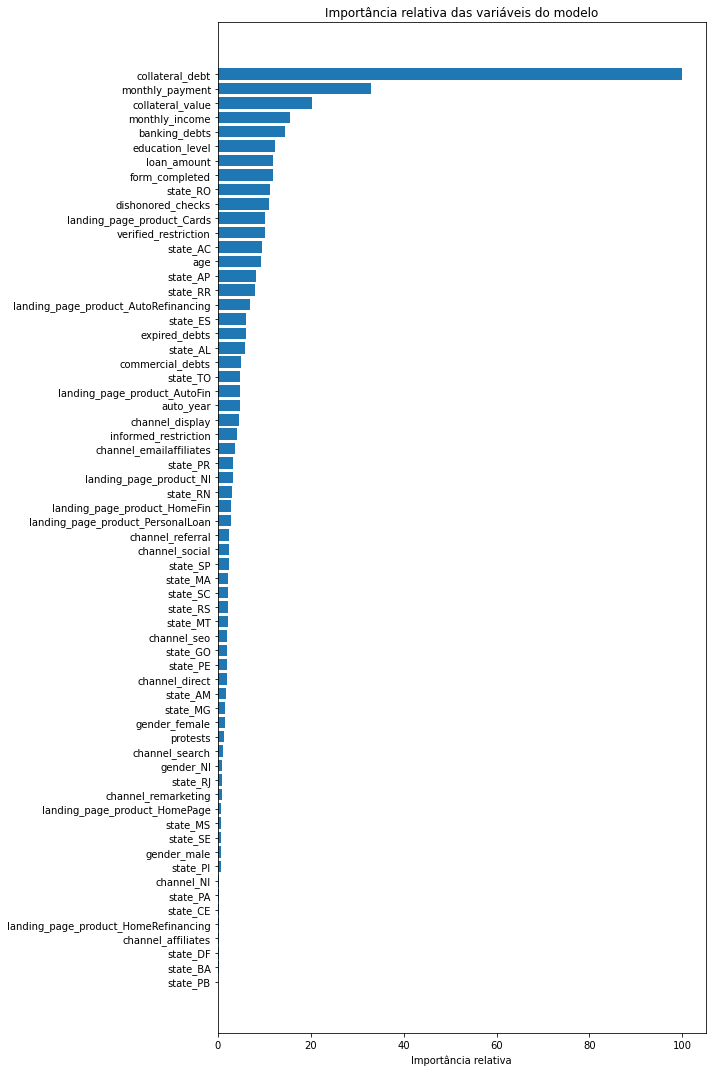

In [16]:
# O modelo escolhido foi Regressão Logística, mas usaremos também na função abaixo outros 3 modelos que performaram bem,
# apenas como métrica de avaliação para retirada de variáveis não importantes para o modelo.
def avaliar_modelo(X, y): 
    score_medio = []

    clf = tree.DecisionTreeClassifier()
    scores = cross_val_score(clf, X, y, cv=4)
    score_medio.append(scores.mean())

    clf = SGDClassifier(loss="hinge", max_iter=20, tol=-np.infty)
    scores = cross_val_score(clf, X, y, cv=4)
    score_medio.append(scores.mean())

    clf = RandomForestClassifier(n_estimators=40)
    scores = cross_val_score(clf, X, y, cv=4)
    score_medio.append(scores.mean())

    clf = LogisticRegression(solver='lbfgs', max_iter=200)
    scores = cross_val_score(clf, X, y, cv=4)
    score_medio.append(scores.mean())

    return(np.array(score_medio).mean())

# Gráfico que nos mostra as variáveis mais importantes para o modelo, além das variáveis menos importantes que podemos pensar em remover.
clf = LogisticRegression(solver='lbfgs', max_iter=200).fit(X, y)
imp_var = abs(clf.coef_[0])
imp_var = 100.0 * (imp_var / imp_var.max())
sorted_idx = np.argsort(imp_var)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, imp_var[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
featax.set_xlabel('Importância relativa')
plt.title('Importância relativa das variáveis do modelo')
plt.tight_layout()   
plt.show()

### - Recursive Feature Selection

Rankear de modo recursivo as variáveis mais importantes para o modelo

In [23]:
estimator = LogisticRegression(solver='lbfgs', max_iter=200, random_state=123)
selector = RFE(estimator, 1, step=1, n_features_to_select=1)
selector = selector.fit(X, y)
selector.ranking_   # Ranking de importância das variáveis para o modelo preditivo.

array([16,  3,  5,  6,  1,  2, 29,  8,  7, 12, 18,  4, 21, 39, 25, 11, 10,
       17, 47, 20, 63, 57, 58, 23, 46, 28, 48, 55, 44, 59, 64, 45, 51, 40,
       49, 41,  9, 14, 43, 26, 54, 42, 27, 61, 62, 37, 22, 24, 35, 50, 38,
       36, 34, 30, 15, 13, 31, 56, 60, 33, 19, 52, 32, 53])

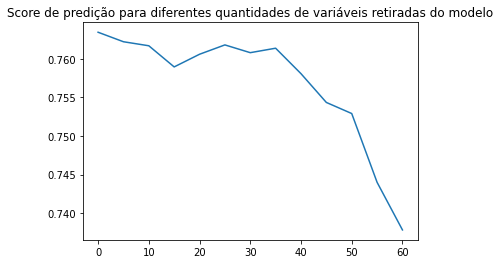

In [24]:
# Conferir se a retirada de variáveis menos importantes resultará em perda significativa no poder preditivo
ndrop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
nval = []

for i in (ndrop):
    ranking = pd.DataFrame([selector.ranking_, X.columns]).transpose()
    ranking.columns = ['ranking', 'variavel']
    piores = ranking.sort_values('ranking').tail(i)['variavel']
    Xs = X.drop(piores, axis=1)
    nval.append(avaliar_modelo(Xs, y))
plt.title('Score de predição para diferentes quantidades de variáveis retiradas do modelo')
plt.plot(ndrop, nval)
plt.show()

#### Notamos que a partir de um determinado número de variáveis retiradas, o score começa a cair. No próximo passo vamos identificar quais variáveis são menos importantes, e então retirá-las do modelo caso elas não tenham nenhum impacto positivo.

### - Construir modelo de Regressão Logística

O modelo de regressão logística é utilizado para fornecer à máquina um aprendizado supervisionado de classificação binária. Para isso, fornecemos ao algoritimo um conjunto de dados históricos X devidamente tratados com informações sobre cada registro (no caso, cada cliente), e uma variável resposta y (no caso, enviado ou não para análise de crédito). O algorítimo será treinado a reconhecer quais são as características dos clientes que não são enviados para análise, e quais características dos clientes que são enviados para análise. Após ja ter sido treinado, poderemos passar  dados sobre novos clientes, e então o algoritimo será capaz de nos fornecer a probabilidade que cada cliente tem de ser enviado para a análise de crédito.

In [25]:
# Construir modelo de Regressão Logística
clf = LogisticRegression(solver='lbfgs', max_iter=200)
scores = cross_val_score(clf, X, y, cv=4)
print('Score do modelo: {:.3f}'.format(scores.mean()))

Score do modelo: 0.785


O módulo stats da biblioteca scipy nos fornece informações detalhadas sobre modelos estatísticos criados. Portanto, vamos usá-lo para criar um modelo de Regressão Logística e usar o valor-p de cada parâmetro do modelo como método de seleção de variáveis. Utilizaremos um nivel de significância de 5%, ou seja, procuraremos manter apenas as variáveis referentes aos parâmetros com valor-p inferior a 0.05, pois são elas as mais importantes para o modelo.


#### Explicação sobre valor-p: 
##### Para cada coeficiente do modelo, temos duas hipóteses:
##### - Hipótese nula (H0): o coeficiente não é significativamente diferente de 0.
##### - Hipótese alternativa (H1): o coeficiente é significativamente diferente de 0.

##### Ao nível de 5% de significância estabelecido, um valor-p inferior a 0.05 evidencia a rejeição da hipótese nula, ou seja, temos evidências de que a variável possui um impacto significativo no modelo.

##### Por esse motivo, estamos mais interessados nas variáveis que tiverem um coeficiente com valor-p inferior a 0.05.

In [26]:
# Criar modelo logístico e imprimir sumário
from scipy import stats
import statsmodels.api as sm
est = sm.Logit(y, X)
est = est.fit(solver='lbfgs', random_state=0)
print(est.summary())

         Current function value: 0.443600
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:       sent_to_analysis   No. Observations:                13422
Model:                          Logit   Df Residuals:                    13361
Method:                           MLE   Df Model:                           60
Date:                Sat, 06 Nov 2021   Pseudo R-squ.:                  0.1774
Time:                        17:44:24   Log-Likelihood:                -5954.0
converged:                      False   LL-Null:                       -7238.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
age                                      0.9503      0.140      6.772      0.000       0.675

C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
# Selecionar variáveis com p-valor < 0.05
# Obs: apesar da variável loan_amount ter p-valor maior do que o nível de significância previamente estipulado, manteremos a variável no modelo, pois o p-valor não está
# tão alto quanto as demais variáveis, e no estudo que fizemos anteriormente percebemos pelo gráfico que ela pode ser uma variável importante para o modelo.
res_summary = est.summary()
res_html = res_summary.tables[1].as_html()
valor_p = pd.read_html(res_html, header=0, index_col=0)[0]['P>|z|'].sort_values()
var_mantidas = valor_p[valor_p < 0.2].index
var_mantidas

Index(['age', 'collateral_value', 'collateral_debt', 'monthly_payment',
       'education_level', 'verified_restriction', 'form_completed',
       'banking_debts', 'informed_restriction', 'monthly_income', 'auto_year',
       'commercial_debts', 'dishonored_checks', 'loan_amount'],
      dtype='object')

### - Matriz de correlação

<AxesSubplot:>

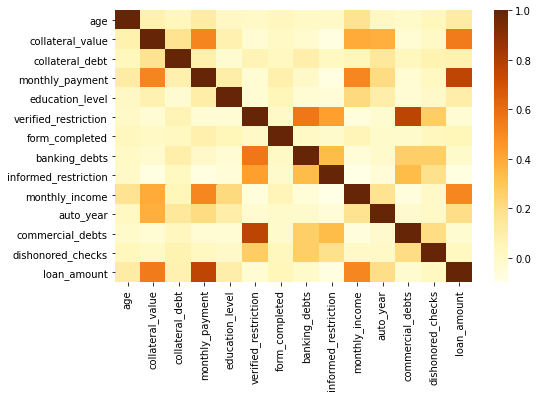

In [28]:
# Plotar matriz de correlação entre variáveis remanescentes
Xs = X[var_mantidas]
corr = Xs.corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, cmap ='YlOrBr')

O gráfico acima mostra cores mais escuras entre variáveis fortemente correlacionadas (correlações próximas de 1 ou -1) e cores claras para variáveis fracamente correlacionadas (correlações próximas de 0). Podemos notar que não existem fortes correlações entre as variáveis, isso é muito importante pois evitamos assim problemas de multicolinearidade que causam  inflação da variância do modelo.
Obs: a diagonal principal está escura pois trata-se da correlação de uma variável com ela mesmo. Uma variável sempre será perfeitamente correlacionada com ela mesma.

### - Recriar modelo de Regressão Logística usando apenas variáveis selecionadas

In [29]:
Xs = X[var_mantidas]
X_test = X_test[var_mantidas]   # precisamos manter o banco de teste com as mesmas variáveis do banco usado para treino e validação
clf = LogisticRegression(solver='lbfgs', max_iter=200)
scores = cross_val_score(clf, Xs, y, cv=4)
print('Score do modelo final: {:.3f}'.format(scores.mean()))

Score do modelo final: 0.785


#### Depois de retirar as variáveis que acreditamos não ser importantes, o modelo permaneceu com o mesmo score.
#### Esse será o nosso modelo final!

___
## __INTERPRETAÇÃO DO MODELO__

In [30]:
from scipy import stats
import statsmodels.api as sm
est = sm.Logit(y, Xs)
est = est.fit(solver='lbfgs', max_iter=200)

res_summary = est.summary()
res_html = res_summary.tables[1].as_html()
pd.read_html(res_html, header=0, index_col=0)[0]

Optimization terminated successfully.
         Current function value: 0.467095
         Iterations 9


,coef,std err,z,P>|z|,[0.025,0.975]
age,0.3814,0.130,2.933,0.003,0.127,0.636
collateral_value,-2.6768,0.841,-3.181,0.001,-4.326,-1.028
collateral_debt,-31.0039,2.347,-13.208,0.000,-35.605,-26.403
monthly_payment,4.6666,0.735,6.348,0.000,3.226,6.107
education_level,0.1975,0.121,1.628,0.104,-0.040,0.435
verified_restriction,-0.9653,0.205,-4.713,0.000,-1.367,-0.564
form_completed,1.0869,0.047,23.324,0.000,0.996,1.178
banking_debts,-1.6979,0.412,-4.117,0.000,-2.506,-0.890
informed_restriction,-0.5224,0.081,-6.478,0.000,-0.680,-0.364
monthly_income,2.4864,0.421,5.912,0.000,1.662,3.311


O index do DataFrame acima mostra o nome de cada variável do modelo. A coluna "coef" mostra o coeficiente pelo qual o valor observado de cada variável de um novo registro será multiplicado para chegarmos ao nosso valor de output. Isso nos mostra como cada variável impacta na predição da variavel resposta.
- **Exemplo 1:** a variável **collateral_debt** possui coeficiente negativo (-31.0039). Isso significa que enquanto maior o valor que o automóvel tem de dívida, menor a probabilidade de ser enviado para análise de crédito. Uma observação importante: o valor absoluto do coeficiente dessa variável é muito maior do que os demais, o que nos mostra que é a variável mais importante para o modelo. Isso é uma confirmação do que vimos no gráfico de importância relativa das variáveis, onde "collateral_debt" foi considerada de longe a variável mais importante.

- **Exemplo 2:** a variável **education_level** possui coeficiente positivo (0.1975). Isso significa que enquanto maior o nível de escolaridade, maior a probabilidade de ser enviado para análise de crédito.

- **Exemplo 3:** a variável **verified_restriction** possui coeficiente negativo (-0.9653). Isso significa que se o cliente possui alguma restrição/pendência verificada, ele terá menor probabilidade de ser enviado para análise de crédito.

- **Exemplo 4:** a variável **banking_debts** possui coeficiente negativo (-1.6979). Isso significa que se o cliente possui alguma dívida bancária, ele terá menor probabilidade de ser enviado para análise de crédito.

- **Exemplo 5:** a variável **monthly_income** possui coeficiente positivo (2.4864). Isso significa que enquanto maior a renda mensal informada, maior a probabilidade de ser enviado para análise de crédito.

___
## __AVALIAÇÃO DO MODELO__ 
#### Nosso modelo final de Regressão Logística foi capaz de predizer corretamente se o cliente foi ou não enviado para análise de crédito em 78.5% das vezes.
- As variáveis usadas na modelagem não possuem fortes correlações entre elas
- O modelo foi testado em uma porção do banco de dados que não foi utilizada nem para treinamento e nem para a avaliação do modelo e dos hyperparâmetros. Isso significa que os dados usados para testar o poder final de predição do modelo são completamente novos.

---
## __PREDIÇÃO PARA DADOS DE TESTE__
Fazer predição para os 10% do banco de dados separado para o teste final.

In [31]:
clf.fit(Xs, y)
prob = clf.predict_proba(X_test)
prob = np.array(pd.DataFrame(prob)[1])
len(prob)
len(id_test)
output = pd.concat([pd.Series(id_test).reset_index(drop=True), pd.Series(prob)], axis=1)
output.columns = ['id', 'prob']
id_resp = output.merge(dataset, on='id')[['id', 'sent_to_analysis']]

output = output.merge(id_resp, on='id')
output.head()

,id,prob,sent_to_analysis
0,114145,0.152046,0.0
1,114144,0.014769,0.0
2,114139,0.009077,0.0
3,114137,0.061602,0.0
4,114135,0.052025,0.0


___
## __CURVA ROC__

A Curva ROC nos ajuda a determinar um threshold (limiar) de qual valor entre 0 e 1 podemos usar como ponto crítico. Podemos determinar um valor de modo que qualquer cliente que receba uma probabilidade acima desse valor será classificado como um provavel enviado para análise de crédito.
Não precisamos definir esse limiar, pois o objetivo do projeto é atribuir a probabilidade entre 0 e 1, e não classificar como ser ou não enviado para análise de crédito. Porém, vamos analisar a Curva ROC para termos uma percepção visual do quão bem ajustado ficou nosso modelo.

AUC: 0.890


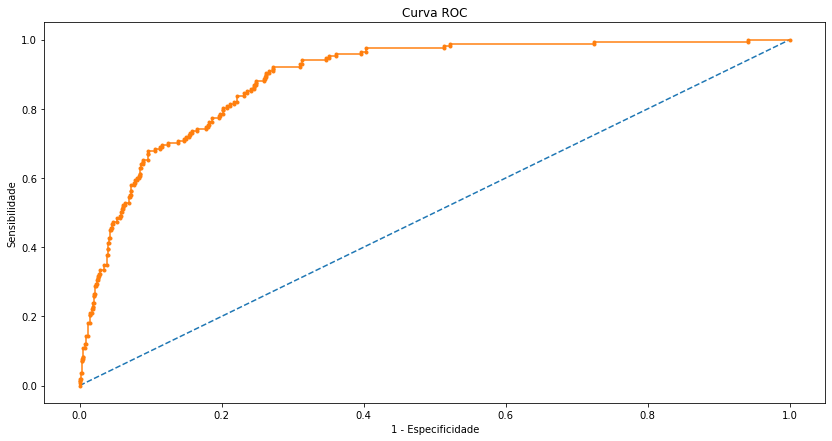

In [32]:
#Calcular AUC (Área sob a curva)
auc = roc_auc_score(output['sent_to_analysis'], output['prob'])
print('AUC: {:.3f}'.format(auc))

# Calcular e plotar curva ROC
fpr, tpr, thresholds = roc_curve(output['sent_to_analysis'], output['prob'])
plt.figure(figsize=(14,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('Curva ROC')
plt.xlabel('1 - Especificidade')
plt.ylabel('Sensibilidade')
pyplot.show()

- **Sensibilidade:** capacidade do modelo em identificar corretamente os clientes que serão enviados para análise de crédito
- **Especificidade:** capacidade do modelo em identificar corretamente os clientes que NÃO serão enviados para análise de crédito
- **Linha tracejada azul:** modelo hipotético que classifica aleatoriamente clientes como enviados e não enviados para análise de crédito
- **Linha laranja:** modelo de Regressão Logística criado para predizer se os clientes serão ou não enviados para análise de crédito
- Enquanto mais próximo do canto superior esquerdo a curva laranja passar, ou seja, enquanto maior a área sob a curva laranja, melhor é a capacidade preditiva do nosso modelo. 
#### A área total do gráfico acima é 1. 
#### Nossa AUC (área sob a curva) é de 0.89, valor alto que nos informa que temos um modelo com boa capacidade preditiva.

---
## __CONCLUSÃO__

### **Objetivo alcançado!!!**

**CONSTRUÇÃO DO MODELO:** O objetivo desse estudo era atribuir valores entre 0 e 1 para cada cliente, representando a probabilidade de cada cliente ser enviado para análise de crédito. Alcançamos o objetivo! Chegamos ao output informando o id de cada cliente e sua respectiva probabilidade de ser enviado para análise de crédito, permitindo assim estabelecermos uma ordem otimizada de atendimento aos clientes.

**INTERPRETAÇÃO DO MODELO:** Interpretamos o modelo, explicando como o mesmo funciona, mostramos quais são as variáveis mais importantes e como elas afetam a predição.

**AVALIAÇÃO DO MODELO:** Usamos 90% dos dados disponíveis para escolher, treinar e tunar nosso modelo, e deixamos os 10% restantes para testar nosso modelo final. Para 78.5% dos clientes, conseguimos acertar se ele foi ou não enviado para a análise de crédito. Relembrando: o grande objetivo do estudo não é predizer se o cliente será ou não enviado para a análise de crédito, e sim atribuir uma probabilidade para cada um, de modo a otimizarmos a preferência no atendimento. Fizemos essa classificação com os 10% do banco de dados apenas como forma de avaliar nosso modelo. Para complementar nossa avaliação, fizemos a Curva ROC que mostrou que o modelo possui opções de treshold com boa sensibilidade e boa especificidade. Confirmando o bom ajuste do modelo, temos uma área sob a curva (AUC) de 0.89.
___

# __FIM__